In [1]:
%load_ext autoreload
%autoreload 2

# some magic to be able to import local module into jupyter notebook
# https://mg.readthedocs.io/importing-local-python-modules-from-jupyter-notebooks/index.html
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from dynamite_src import gauss_hermite_kinematics as ghk
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Aim: implement weight-solving

Take orbit librarys calculated by triaxschwarz and then solve for orbital weights given some kinemtics files. Do this all in the new framework.

Initital steps:
- read orbit librarys generated by triaxschwarz
- read input kinemtaics
- convert these into *sensible file formats*
- construct NNLS matrix
- solve NNLS

What do I think is a *sensible file format*?
- human readible if possilbe
- ... if not possible (e.g. orbit library is too large and hence must be in binary format) then make it as human readable as possible
- simple function to read the file... e.g. any complexity of reading the file should be in the file-header itself

I like astropy ascii.ecsv files ... they tick the three boxes above.

Also, the filetypes should be compatible for the new dynamite-structure e.g. different options for input kinemtics may have different column headings (e.g. h0, h1, h2, h3... vs h3, h4, ...). Make flexible enough to deal with this.

In [2]:
gauherm = ghk.GaussHermite()

old_file = '../datafiles/triaxschwarz_example/infil/kin_data.dat'
new_file = '../datafiles/gauss_hermite_kins.ecvs'

dat1 = gauherm.read_file_old_format(old_file)
gauherm.convert_file_from_old_format(old_file, new_file)
dat2 = gauherm.read_file(new_file)

dat2

vbin_id,v,dv,sigma,dsigma,h3,dh3,h4,dh4
int64,float64,float64,float64,float64,float64,float64,float64,float64
1,-55.1457,2.0968,193.5,2.0798,0.077,0.3,0.0,0.3
2,-72.0331,2.1187,173.297,2.2978,0.1006,0.3,0.0,0.3
3,-70.3214,2.9704,157.694,3.0237,0.0983,0.3,0.0,0.3
4,-59.3916,2.641,179.503,2.6,0.083,0.3,0.0,0.3
5,-42.9252,2.627,203.949,2.4986,0.06,0.3,0.0,0.3
6,-76.6923,4.1897,153.159,4.2396,0.1072,0.3,0.0,0.3
7,-60.8558,2.8168,154.194,3.0038,0.085,0.3,0.0,0.3
8,-45.534,2.6694,184.95,2.801,0.0636,0.3,0.0,0.3
9,-73.7064,3.3263,133.986,3.5988,0.103,0.3,0.0,0.3


Now... to read the orbit libraries.

schwpy zips/unzips these for fortran with the commands:

    test -e datfil/orblib.dat.bz2 || bzip2 -k datfil/orblib.dat
    test -e datfil/orblib.dat || bunzip2 -k  datfil/orblib.dat.bz2

I tried using pythons bz2 module to read the zipped files, but it looked like nonsense. So, for now, bunzip by hand in the terminal. This produces a binary file.

How can we read this binary file? It's a bit opaque. Let's see how the current code does it.

Firstly, how was it written? This is lines 2457 - 4465 of orblib_f.f90:

       if (error/=0) stop "  Error opening file."
       ! Write orbit library header in *binary* (typically orblib.dat)
       open (unit=out_handle,iostat=error,file=out_file,action="write", &
            status="new",form="unformatted")
       call integrator_setup_write(out_handle)
       call qgrid_setup_write   (out_handle)
       call histogram_setup_write  (out_handle)
       close(unit=out_handle,iostat=error)
       if (error/=0) stop "  Error closing file."

All the work is done in the functions:

    integrator_setup_write
    qgrid_setup_write
    histogram_setup_write

These write a bunch of stuff into the output file. Data, meta-data, integers, floats all bundled together. Reading this won't be nice. How is it currently read? This is done in triaxnnls.f90, twice (once per orblib). The metadata for obrfile 1 is read in lines 1271-1281:

      open (unit=27,file=orbfile1,action="read", &
           status="old",form="unformatted",position="rewind")
      read (unit=27) norb(1),t1,t2,t3,ndith(1)
      read (unit=27) smom1,sph1,sth1,slr1
      smom1=16
      allocate(quad_lr(slr1+1),quad_lth(sth1+1),quad_lph(sph1+1),&
           quad_light(smom1,sph1,sth1,slr1),quad_store(smom1,sph1,sth1,slr1))
      read (unit=27) quad_lr (:)
      read (unit=27) quad_lth(:)
      read (unit=27) quad_lph(:)
      read (unit=27) nconstrl(1), nvhist(1), dvhist(1)

and then the actual histograms are read in line-by-line, inside a loop, 

      do i=1,2 ! loop over orbit libraries
         print*," Reading orbitlibrary :",i

         allocate(orbtypes(ndith(i)**3))

         do j=1,norb(i) ! loop over orbits
            read (unit=26+i) t1,t2,t3,t4
            if (t1 /= j) stop " orbit number does not match"
            read (unit=26+i) orbtypes(:)
            read (unit=26+i) quad_light(:,:,:,:)
            velhist(:,:)=0.0_dp

            do k=1,nconstr ! loop over apertures
               read (unit=26+i) ivmin, ivmax
               if (ivmin <= ivmax) &
                    read (unit=26+i) velhist(ivmin:ivmax,k)
            end do
      
         ...

Right. Now I'd like to read this to use in python. Any simple options...?

Scipy has a FotranFile object!

In [36]:
from scipy.io import FortranFile

orblibfname = '../datafiles/triaxschwarz_example/'
orblibfname += 'bh6.00dc1.00f2.00q0.50p0.990u0.9999/datfil/orblib.dat'
orblibf = FortranFile(orblibfname, 'r')

In [37]:
# from integrator_setup_write, lines 506 - 5129:
#  t1=  (nEner*nI2*nI3/integrator_dithering**3)
#  t2= nEner/integrator_dithering
#  t3= nI2/integrator_dithering
#  t4= nI3/integrator_dithering
tmp = orblibf.read_ints(np.int32)
norb, t2, t3, t4, ndith = tmp

In [38]:
# from qgrid_setup_write, lines 2339-1350:
#     ! remember that N bins have N+1 boundaries
#     write (unit=hdl) size(quadrant_light,1),size(quad_lph)-1,size(quad_lth)-1,size(quad_lr)-1
#     write (unit=hdl) quad_lr (:)
#     write (unit=hdl) quad_lth(:)
#     write (unit=hdl) quad_lph(:)
tmp = orblibf.read_ints(np.int32)
size_ql_1, size_qph_minus1, size_qth_minus1, size_qlr_minus1 = tmp
quad_lr = orblibf.read_reals(float)
quad_lth = orblibf.read_reals(float)
quad_lph = orblibf.read_reals(float)

In [39]:
# from histogram_setup_write, lines 1917-1926:
#     t1 = hist_basic(1,3)/2.0_sp ! corrected by Remco 20/JAN/2003
#     write (unit=handle) h_nconstr, t1, hist_basic(1,1)/hist_basic(1,3)
tmp = orblibf.read_record(np.int32, np.int32, float)
nconstr = tmp[0][0]
nvhist = tmp[1][0]
dvhist = tmp[2][0] 

Next read the histograms themselves. I can't see where they are written! But this is how they're read in nnls:

     do j=1,norb(i) ! loop over orbits
        read (unit=26+i) t1,t2,t3,t4
        if (t1 /= j) stop " orbit number does not match"
        read (unit=26+i) orbtypes(:)
        read (unit=26+i) quad_light(:,:,:,:)
        velhist(:,:)=0.0_dp
    
        do k=1,nconstr ! loop over apertures
           read (unit=26+i) ivmin, ivmax
           if (ivmin <= ivmax) &
                read (unit=26+i) velhist(ivmin:ivmax,k)
        end do

In [40]:
print(nconstr, nvhist, norb, ndith)

orbtypes = np.zeros((norb, ndith**3), dtype=int)
nbins_vhist = 2*nvhist + 1
velhist = np.zeros((norb, nbins_vhist, nconstr))


152 101 60 1


In [41]:
for j in range(norb):
    t1,t2,t3,t4,t5 = orblibf.read_ints(np.int32)
    orbtypes[j, :] = orblibf.read_ints(np.int32)
    quad_light = orblibf.read_reals(float)
    for k in range(nconstr):
        ivmin, ivmax = orblibf.read_ints(np.int32)
        if (ivmin <= ivmax):
            velhist[j, ivmin+nvhist:ivmax+nvhist+1, k] = orblibf.read_reals(float)

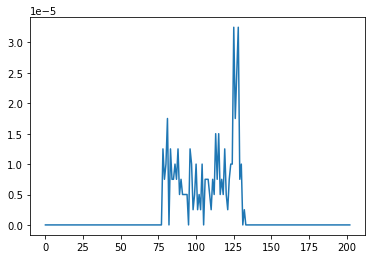

In [49]:
plt.plot(velhist[59, :, 0])

This seems to work... I think. Let's put it all together into a function.